In [1]:
import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, pinv
%matplotlib inline
np.set_printoptions(precision=12, suppress=True)

In [2]:
zoomed_coords = True # whether to divide coordinates by SCALE_FAC or not (zoomed coords or not)
center_only = True # use only central stars
SCALE_FAC = 4.0 # Scale factor of coordinates

In [3]:
"""
Load star coords from txt-files
""";

In [4]:
coords_folder = 'data/star_coords/2016nov-11_txt/' # folder with coords files
images_folder = 'data/stars/2016nov-11/'
results_folder = 'results/2016nov-11/exp-Feb-2017'

In [5]:
# 2016nov-11 jpg
fnames = [
    "20161122-191517-359.txt",
    "20161121-220921-250.txt"
]

In [6]:
date = fnames[0][:-4]

In [7]:
im = Image.open(images_folder + "mod_" + date + "-1.jpg")
w, h = im.size
print("Image size:", w, h)

Image size: 3072 2304


In [8]:
CENTER_RAD = 1000 # radius(px) of central part
print('CENTER_RAD:', CENTER_RAD)

CENTER_RAD: 1000


In [9]:
x_c, y_c = w/2, h/2 # central point of img
print('x_c, y_c:', x_c, y_c)

x_c, y_c: 1536.0 1152.0


"1." Берем область (круг) с центром в середине кадра, разных радиусов.
Считаем количество звезд. Определяем координаты выделенных звезд,
стараясь брать звезды малого размера, занимающих один пиксель.
Число звезд в кругах должно  отличаться на 3-4.

Например
* R1 = 576px; 11 звезд учитыв-ся при подсчете коэфф
* R2 = 476px; 8 звезд учитыв-ся при подсчете коэфф

In [10]:
"""
Choose central stars (in central circle)
""";

In [11]:
coords_list = []
for fname in fnames:
    piece = np.loadtxt(coords_folder + os.sep + fname)
    coords_list.append(piece)

coords = np.vstack(coords_list)
print('Zoomed In Star coordinates pairs (first 5):\n', coords[:5], '\n')

if zoomed_coords:
    coords /= float(SCALE_FAC)
    coords = coords.round()
    print('Normal Star coordinates pairs (first 5):\n', coords[:5], '\n')


if center_only:
    coords_center = []
    
    for i in range(coords.shape[0]):
        _lx = coords[i, 0]
        _ly = coords[i, 1]
        _rx = coords[i, 2]
        _ry = coords[i, 3]
        if \
        (_lx - x_c)**2 + (_ly - y_c)**2 <= CENTER_RAD**2 and \
        (_rx - x_c)**2 + (_ry - y_c)**2 <= CENTER_RAD**2:
            coords_center.append(coords[i])
    
    coords = np.vstack(coords_center)
    print('Normal Star coordinates pairs in center:\n', coords, '\n')
    print('Num of star pairs chosen:', len(coords))

Zoomed In Star coordinates pairs (first 5):
 [[ 907. 1674. 2124. 1893.]
 [ 795. 2723. 2033. 2932.]
 [1511. 3124. 2734. 3321.]
 [5242. 1219. 6425. 1369.]
 [5587. 4718. 6823. 4900.]] 

Normal Star coordinates pairs (first 5):
 [[ 227.  418.  531.  473.]
 [ 199.  681.  508.  733.]
 [ 378.  781.  684.  830.]
 [1310.  305. 1606.  342.]
 [1397. 1180. 1706. 1225.]] 

Normal Star coordinates pairs in center:
 [[1310.  305. 1606.  342.]
 [1397. 1180. 1706. 1225.]
 [1138. 1124. 1442. 1170.]
 [1310.  305. 1606.  342.]
 [1397. 1180. 1706. 1225.]
 [1138. 1124. 1442. 1170.]] 

Num of star pairs chosen: 6


In [12]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4
print('Number of Star coordinates pairs:', N)

Number of Star coordinates pairs: 6


In [13]:
# Plot chosen star pairs
scatter_original = Image.new('RGB', (w, h), 'lightgray')
s_pix = scatter_original.load()

ELL_RAD = 3

scx_c = scatter_original.width / 2
scy_c = scatter_original.height / 2
draw = ImageDraw.Draw(scatter_original)
draw.ellipse((scx_c-ELL_RAD, scy_c-ELL_RAD, scx_c+ELL_RAD, scy_c+ELL_RAD), fill='darkgreen')

In [14]:
for i in range(N): # draw star points
    draw.ellipse((lX[i]-ELL_RAD, lY[i]-ELL_RAD, lX[i]+ELL_RAD, lY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')

# Draw central part boundary
draw.ellipse((scx_c-CENTER_RAD, scy_c-CENTER_RAD, scx_c+CENTER_RAD, scy_c+CENTER_RAD), outline='black')

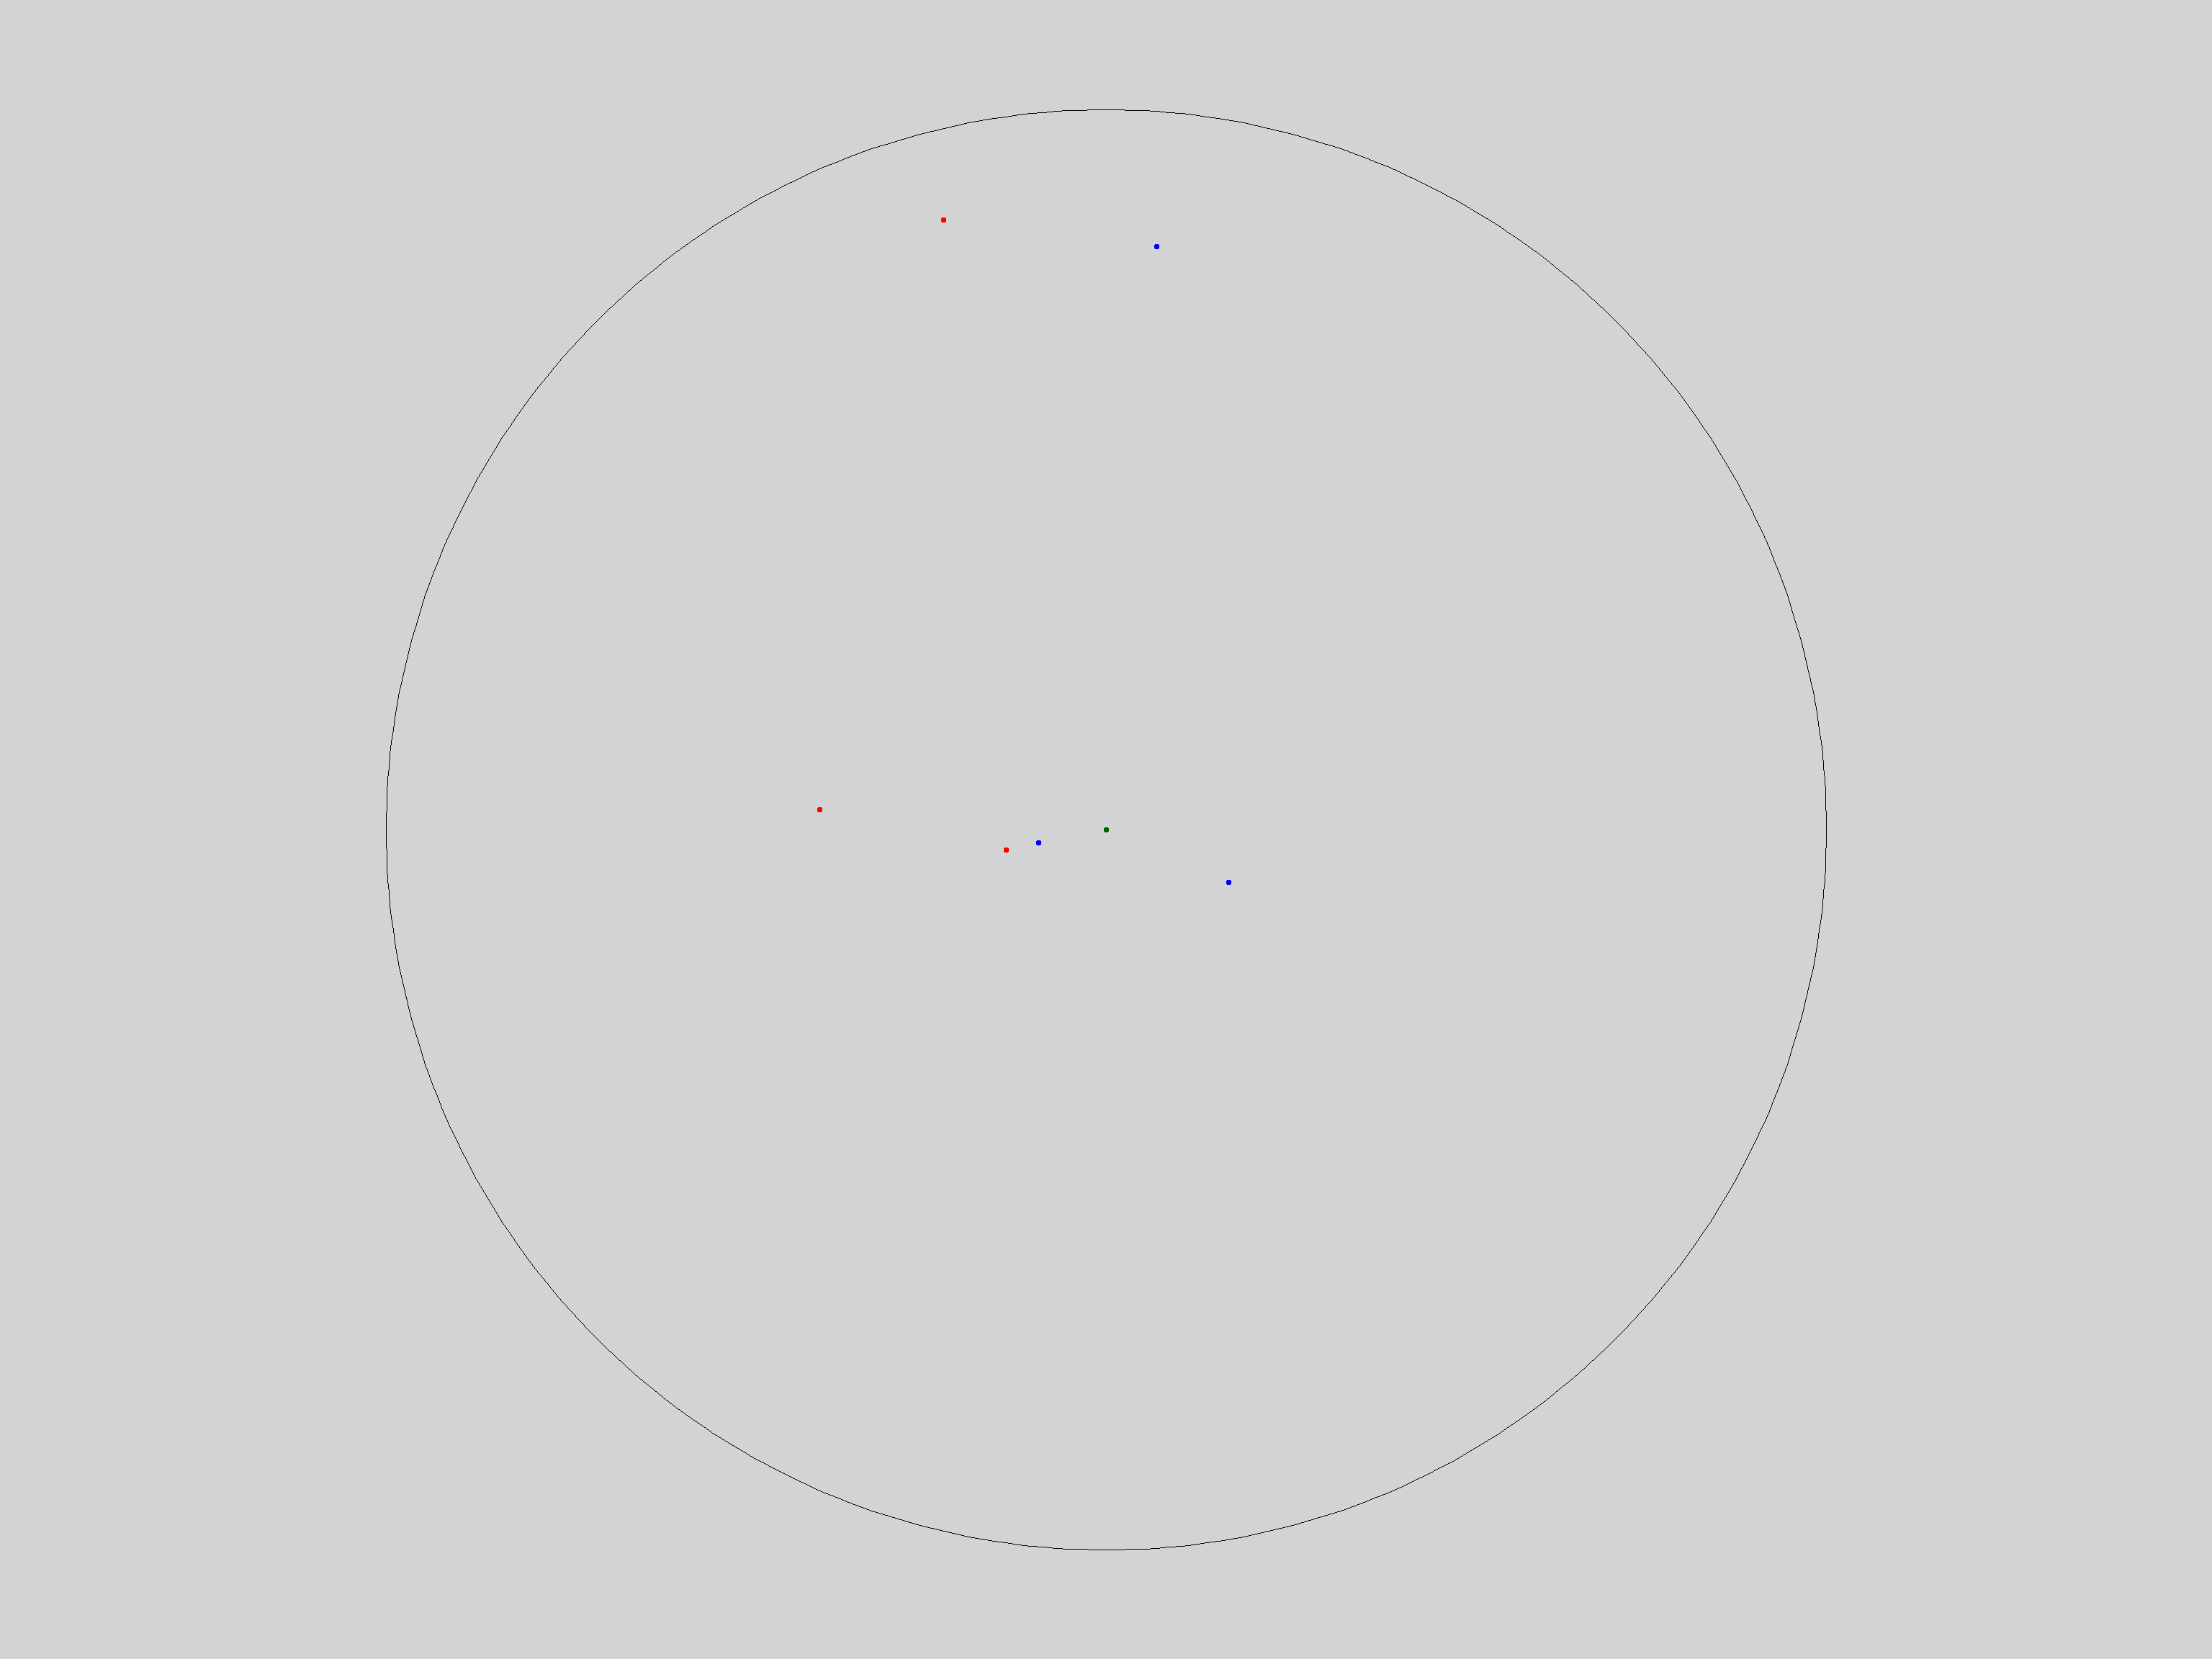

In [15]:
# Original stars' position
scatter_original

"2." Для каждого из набора звезд в выделенных кругах вычисляем
коэффициенты аффинного преобразования, коэффициенты
преобразования аффинного+дисторсии 3 порядка и коэффициенты
преобразования аффинного+дисторсии 3 порядка+дисторсии 5
порядка. Формулу для дисторсии 5 порядка можно посмотреть,
например, на сайте
https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D1%82%D0%BE%D1%80%D1%81%D0%B8%D1%8F

Для дисторсии высших порядков  ($F_{n} при \; n>3$) в формулу добавляют по одному слагаемому на каждую дисторсию нечётного порядка ($F_{3}, F_{5}, F_{7} \;$ и т.п.):

$
\vec{R} = b_{0}\vec {r} + F_{3} r^{2} \vec{r} + F_{5} r^{4} \vec{r} + F_{7} r^{6} \vec{r} + \dots
$

и написать по аналогии с третьим порядком. Число звезд должно быть
больше, чем половина числа неизвестных параметров.

Вычисление проводится так.
Запишем схему измерения
$$
\xi = Af + \nu ,
$$

задаем матрицу А, матрицу $\Sigma$, являющуюся диагональной, и на ее
диагонали стоят дисперсии координат вектора погрешности $\nu$ . Здесь $f$ -- вектор неизвестных коэффициентов преобразований. Считаем эти дисперсии равными единице, т.е. $\Sigma = I$ -- единичная матрица

Оценка коэффициентов вычисляется по формуле
$$
    \hat{f} = A^- \xi
$$

In [16]:
xi = np.zeros(2*N)

for i in range(N): # fill the xi vector
    xi[2*i] = rX[i]
    xi[2*i + 1] = rY[i]

print('xi:\n', xi)

xi:
 [1606.  342. 1706. 1225. 1442. 1170. 1606.  342. 1706. 1225. 1442. 1170.]


In [17]:
"""
Calculate coeff-s

a) Affine (at least 3 stars)
""";

In [18]:
k = 6 # num of coeff-s

z = np.zeros(k)
arr = np.zeros((2*N, k)) # matrix A

In [19]:
for i in range(N): # fill the A matrix
    
    arr[2*i] = [lX[i], lY[i], 0, 0, 1, 0]

    arr[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1]

In [20]:
np.set_printoptions(precision=2, suppress=True)
print('A:\n', arr[:4], '\n')

A:
 [[1310.  305.    0.    0.    1.    0.]
 [   0.    0. 1310.  305.    0.    1.]
 [1397. 1180.    0.    0.    1.    0.]
 [   0.    0. 1397. 1180.    0.    1.]] 



In [21]:
p_arr = pinv(arr)
print(p_arr.dtype)
z = np.dot(p_arr, xi)
print("""
Affine coefficients:
%.4f %.4f %.4f %.4f 
%.2f %.2f""" % tuple(z))
print('cond(A): ', np.linalg.cond(arr))
# NumPy doesn't support float128 

float64

Affine coefficients:
1.0164 0.0132 -0.0060 1.0097 
270.42 41.85
cond(A):  19622.773397763747


In [22]:
"""
b) Affine + Ditortion 3rd order 
  (at least 4 stars)
""";

In [23]:
k3 = 8

z3 = np.zeros(k3)
arr3 = np.zeros((2*N, k3)) # matrix A

In [24]:
for i in range(N): # fill the A matrix
    dist_l = (lX[i]-x_c)**2 + (lY[i]-y_c)**2
    dist_r = (rX[i]-x_c)**2 + (rY[i]-y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zx2 = (rX[i] - x_c) * dist_r
    arr3[2*i] = [lX[i], lY[i], 0, 0, 1, 0, -zx1, zx2]

    zy1 = (lY[i] - y_c) * dist_l
    zy2 = (rY[i] - y_c) * dist_r
    arr3[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1, -zy1, zy2]


In [25]:
np.set_printoptions(precision=2)
print('A:\n', arr3[:4], '\n')
np.set_printoptions(precision=4)

A:
 [[ 1.31e+03  3.05e+02  0.00e+00  0.00e+00  1.00e+00  0.00e+00  1.74e+08
   4.63e+07]
 [ 0.00e+00  0.00e+00  1.31e+03  3.05e+02  0.00e+00  1.00e+00  6.51e+08
  -5.35e+08]
 [ 1.40e+03  1.18e+03  0.00e+00  0.00e+00  1.00e+00  0.00e+00  2.79e+06
   5.82e+06]
 [ 0.00e+00  0.00e+00  1.40e+03  1.18e+03  0.00e+00  1.00e+00 -5.63e+05
   2.50e+06]] 



In [26]:
p_arr3 = pinv(arr3)
z3 = np.dot(p_arr3, xi)
print("""
Affine coefficients + Ditortion 3rd order: 
%.4f %.4f %.4f %.4f 
%.2f %.2f 
%.2e %.2e""" % tuple(z3))
print('cond(A): ', np.linalg.cond(arr3))


Affine coefficients + Ditortion 3rd order: 
1.1009 0.1382 -0.0091 1.0479 
0.00 0.00 
5.42e-07 5.95e-07
cond(A):  8.732201428114359e+24


In [27]:
"""
c) Affine + Ditortion 3rd, 5th orders 
  (at least 5 stars)
""";

In [28]:
k35 = 10

z35 = np.zeros(k35)
arr35 = np.zeros((2*N, k35)) # matrix A

In [29]:
for i in range(N): # fill the A matrix
    dist_l = (lX[i]-x_c)**2 + (lY[i]-y_c)**2
    dist_r = (rX[i]-x_c)**2 + (rY[i]-y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zx2 = (rX[i] - x_c) * dist_r
    wx1 = (lX[i] - x_c) * dist_l**2
    wx2 = (rX[i] - x_c) * dist_r**2

    arr35[2*i] = [lX[i], lY[i], 0, 0, 1, 0, -zx1, zx2, -wx1, wx2]

    zy1 = (lY[i] - y_c) * dist_l
    zy2 = (rY[i] - y_c) * dist_r
    wy1 = (lY[i] - y_c) * dist_l**2
    wy2 = (rY[i] - y_c) * dist_r**2

    arr35[2*i + 1] = [0, 0, lX[i], lY[i], 0, 1, -zy1, zy2, -wy1, wy2]


In [30]:
np.set_printoptions(precision=2, suppress=True)
print('A:\n', arr35[:4], '\n')

A:
 [[ 1.31e+03  3.05e+02  0.00e+00  0.00e+00  1.00e+00  0.00e+00  1.74e+08
   4.63e+07  1.33e+14  3.06e+13]
 [ 0.00e+00  0.00e+00  1.31e+03  3.05e+02  0.00e+00  1.00e+00  6.51e+08
  -5.35e+08  5.00e+14 -3.54e+14]
 [ 1.40e+03  1.18e+03  0.00e+00  0.00e+00  1.00e+00  0.00e+00  2.79e+06
   5.82e+06  5.62e+10  1.99e+11]
 [ 0.00e+00  0.00e+00  1.40e+03  1.18e+03  0.00e+00  1.00e+00 -5.63e+05
   2.50e+06 -1.13e+10  8.55e+10]] 



In [31]:
p_arr35 = pinv(arr35, rcond=1e-18)
z35 = np.dot(p_arr35, xi)
np.set_printoptions(precision=4)
print("""
Affine coefficients + Ditortion 3rd, 5th orders:

%.4f %.4f %.4f %.4f 
%.2f %.2f 
%.2e %.2e 
%.2e %.2e""" % tuple(z35))
print('cond(A): ', np.linalg.cond(arr35))


Affine coefficients + Ditortion 3rd, 5th orders:

1.2497 -0.0138 0.0470 0.9921 
0.00 0.00 
6.58e-07 -4.59e-06 
-1.02e-12 6.78e-12
cond(A):  1.410514376222458e+27


Погрешность оценки коэффициентов определяется матрицей
$$
    \Sigma_f = \left( A^* \Sigma A \right)^{-1} 
             = \left(A^* A \right)^{-1}
$$

In [32]:
"""
Calculate error matrix \Sigma_f
""";

[[1.4637e-05 5.1082e-07 0.0000e+00 0.0000e+00]
 [5.1082e-07 1.0598e-06 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.4637e-05 5.1082e-07]
 [0.0000e+00 0.0000e+00 5.1082e-07 1.0598e-06]]


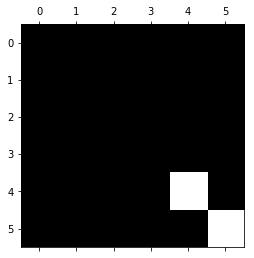

In [33]:
sig_mat = np.linalg.inv(arr.T.dot(arr))
plt.matshow(sig_mat, cmap=plt.cm.gray)
np.set_printoptions(suppress=False)
print(sig_mat[:4, :4])

[[-1.3391e+08  5.0828e+07  3.0498e+08 -1.5234e+09]
 [-1.7818e+08  7.2392e+07  4.1154e+08 -2.0550e+09]
 [ 2.9186e+07 -5.3438e+06 -5.9565e+07  2.9836e+08]
 [-1.7883e+08  3.9920e+07  3.7361e+08 -1.8702e+09]]


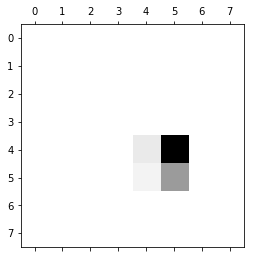

In [34]:
sig_mat3 = np.linalg.inv(arr3.T.dot(arr3))
plt.matshow(sig_mat3, cmap=plt.cm.gray)
np.set_printoptions(suppress=False)
print(sig_mat3[:4, :4])

[[-3.1321e+06  5.2898e+06 -4.9283e+07  2.5595e+08]
 [-3.2350e+06  7.7504e+06  1.0393e+07 -5.2731e+06]
 [-1.7453e+06  5.3504e+06 -5.6969e+07  2.8102e+08]
 [ 6.9478e+06 -2.3315e+07  2.5743e+08 -1.2651e+09]]


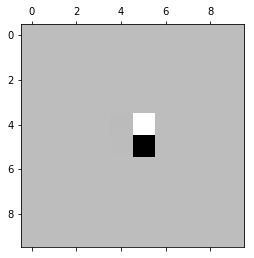

In [35]:
sig_mat35 = np.linalg.inv(arr35.T.dot(arr35))
plt.matshow(sig_mat35, cmap=plt.cm.gray)
np.set_printoptions(suppress=False)
print(sig_mat35[:4, :4])

Надежность модели определяется значением случайной величины
$$
    \tau = \| \xi - AA^{-} \xi \|^2
$$

In [36]:
"""
Calculate reliability of model \tau,
(2N - k) / tau,
N -- number of central stars 
k -- number of coefficients(6, 8 or 10)
""";

In [37]:
N

6

In [38]:
tau = np.linalg.norm(xi - arr.dot(p_arr).dot(xi) ) ** 2
print("tau:", tau)
print("(2N - k) / tau:", (2*N - k) / tau)

tau: 8.892191584945046e-24
(2N - k) / tau: 6.747492946686304e+23


Выходные данные программы:

1) N – число звезд в круге

2) оценка коэффициентов $\; \hat{f} = A^- \xi$

3) матрица ошибок $\; \Sigma_f$

4) значение $\; \tau$ , а лучше – значение $\; \frac{2N - k}{\tau}$,
где k -- число коэффициентов (координат вектора f).

In [39]:
tau3 = np.linalg.norm(xi - arr3.dot(p_arr3).dot(xi) ) ** 2
print("tau3:", tau3)
print("(2N - k3) / tau3:", (2*N - k3) / tau3)

tau3: 2.987863989904702e-13
(2N - k3) / tau3: 13387490238896.65


"3." Вычисляем преобразованное изображение одного из кадров и
накладываем его на изображение второго кадра. Для каждой звезды
вычисляем разность координат (по x и по y) двух (совмещенных) изображений звезд.

In [40]:
tau35 = np.linalg.norm(xi - arr35.dot(p_arr35).dot(xi) ) ** 2
print("tau35:", tau35)
print("(2N - k35) / tau35:", (2*N - k35) / tau35)

tau35: 0.0017948598864880709
(2N - k35) / tau35: 1114.2931072538026


In [41]:
def affine_transform_point(x, y):
    return [b * y + x * a + e , d * y + x * c + f]

In [42]:
"""
Align images and blend

a) Affine
""";

In [43]:
a = float(z[0])
b = float(z[1])
c = float(z[2])
d = float(z[3])
e = float(z[4])
f = float(z[5])

In [44]:
nlX = np.zeros_like(lX)
nlY = np.zeros_like(lY)

In [45]:
# Calc new (affine transformed) points
for i in range(N): 
    nlX[i], nlY[i] = affine_transform_point(lX[i], lY[i])

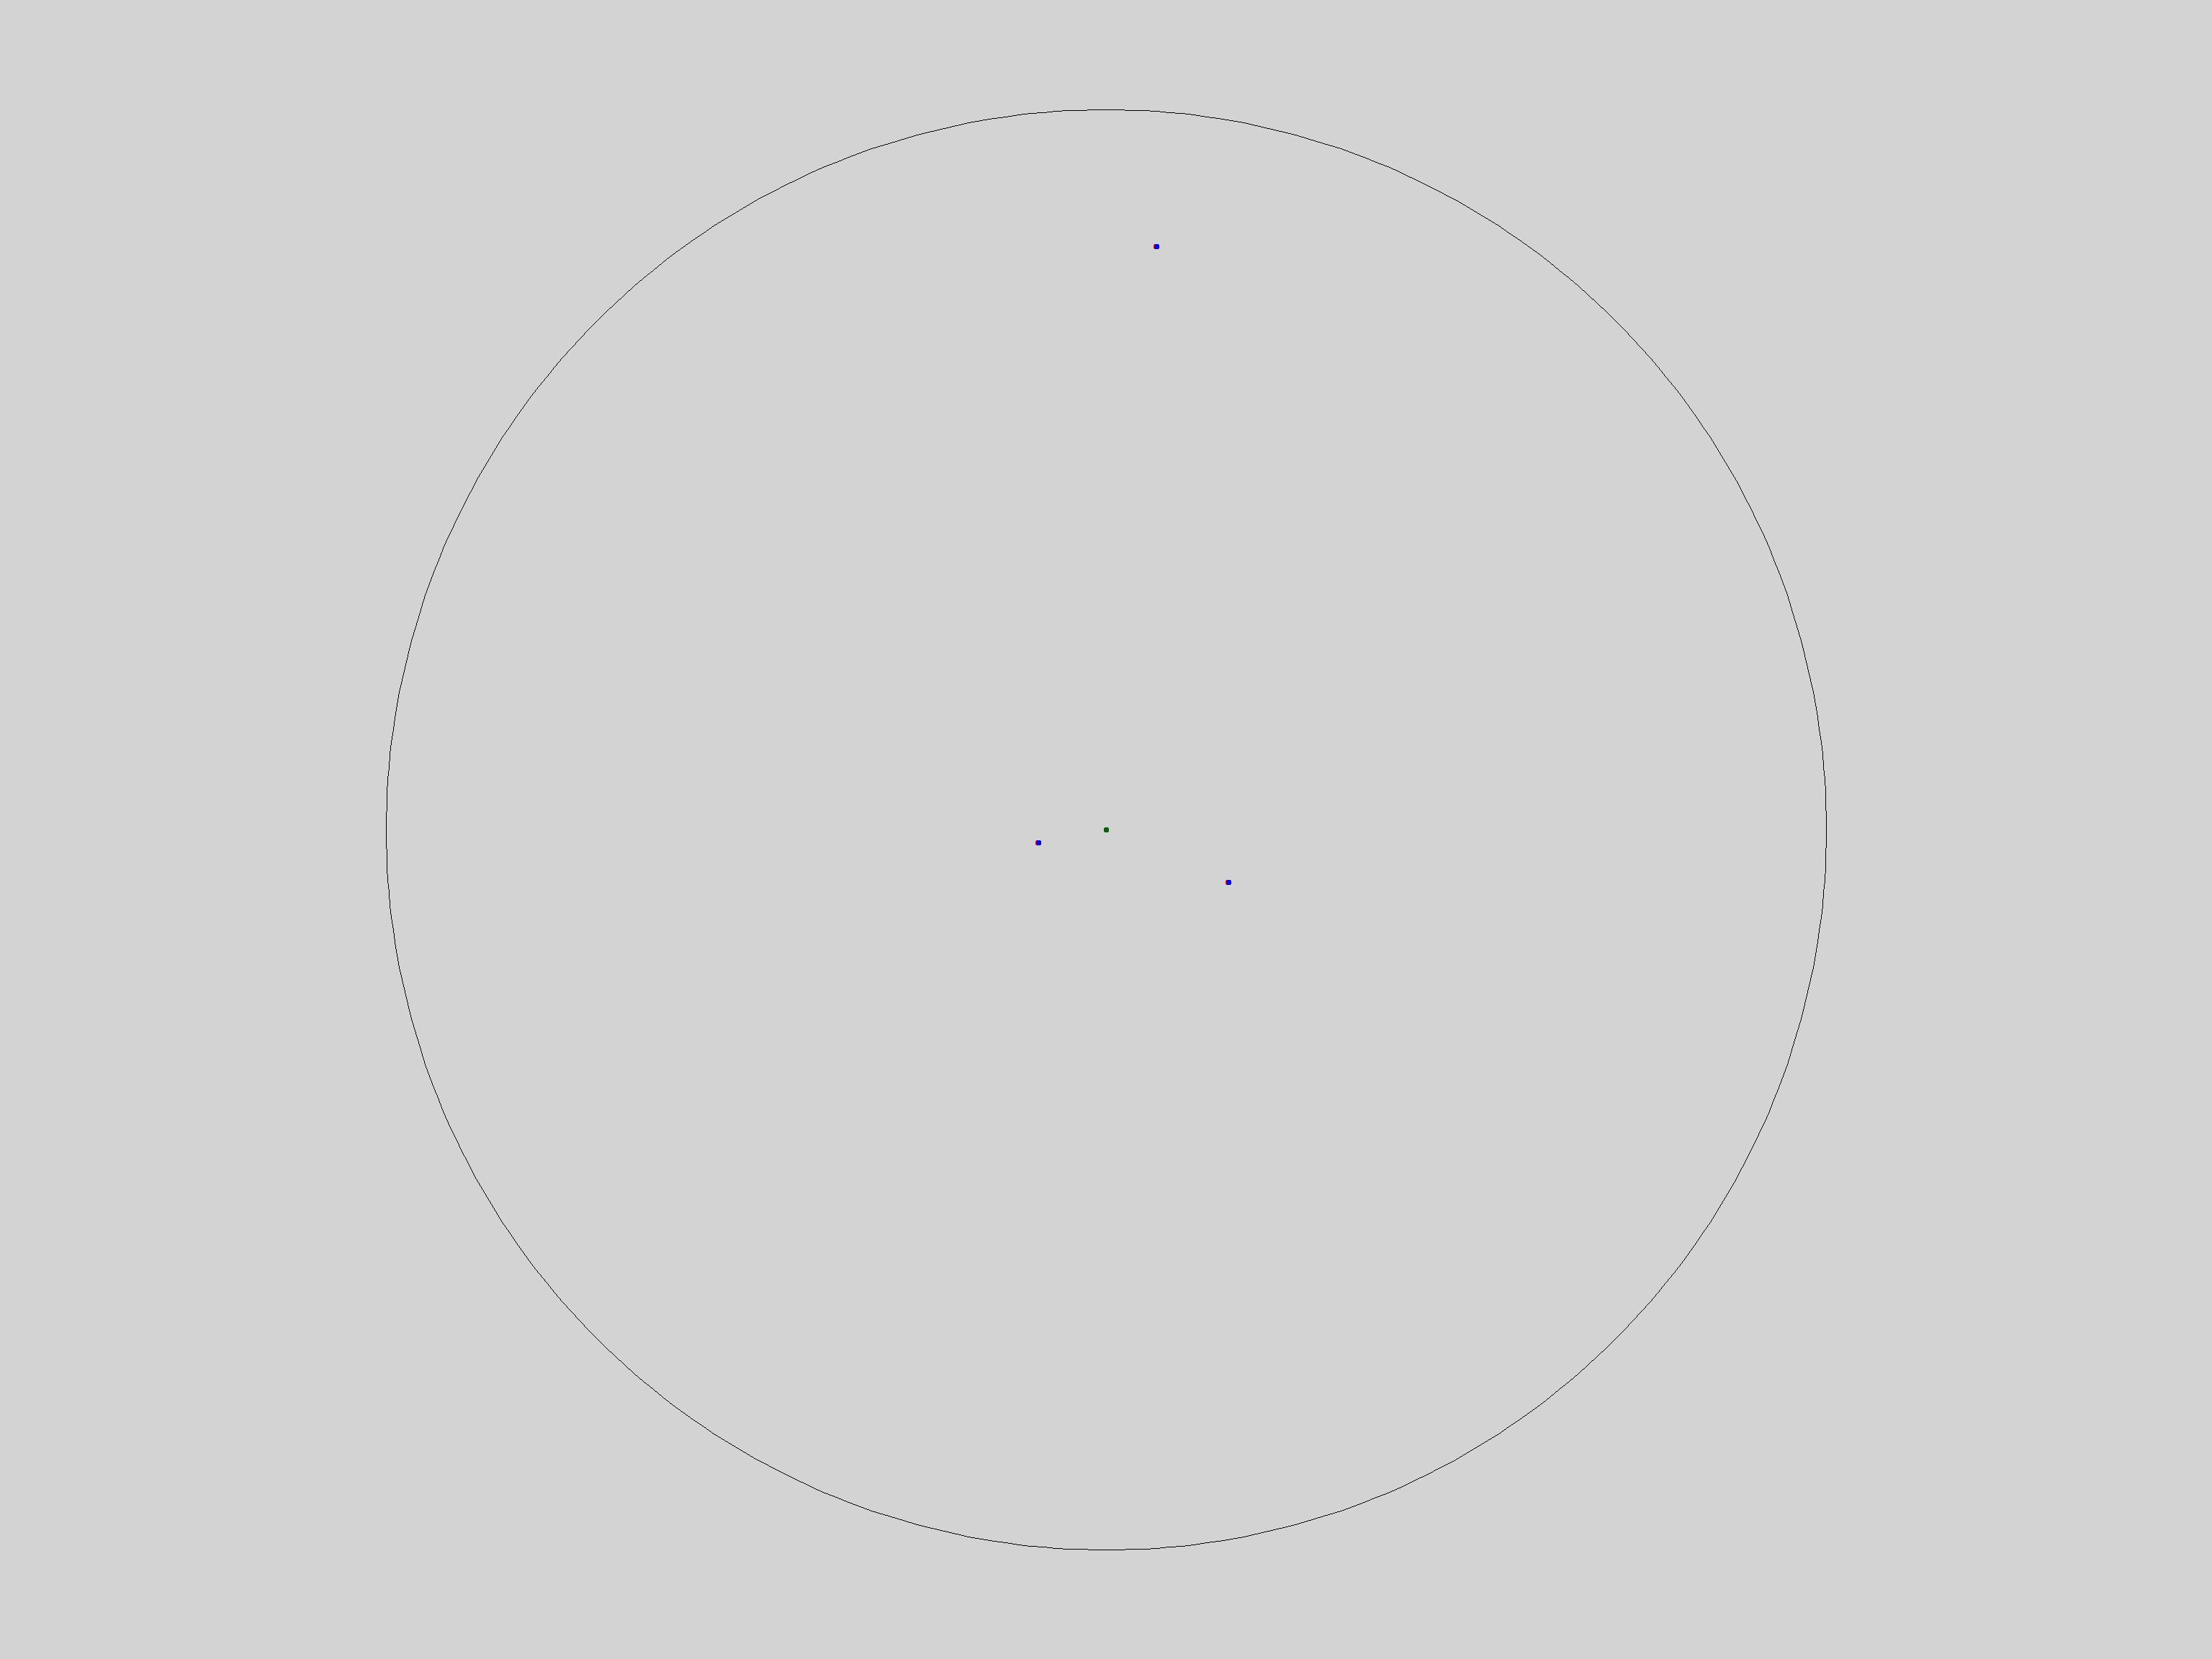

In [46]:
scatter = Image.new('RGB', (w, h), 'lightgray')


draw = ImageDraw.Draw(scatter)
draw.ellipse((x_c-ELL_RAD, y_c-ELL_RAD, x_c+ELL_RAD, y_c+ELL_RAD), fill='darkgreen')
# Draw central part boundary
draw.ellipse((x_c-CENTER_RAD, y_c-CENTER_RAD, x_c+CENTER_RAD, y_c+CENTER_RAD), outline='black')

for i in range(N): # draw star points
    draw.ellipse((nlX[i]-ELL_RAD, nlY[i]-ELL_RAD, nlX[i]+ELL_RAD, nlY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')
scatter

In [47]:
"""
b) Affine + Ditortion3
""";

In [48]:
a = float(z3[0])
b = float(z3[1])
c = float(z3[2])
d = float(z3[3])
e = float(z3[4])
f = float(z3[5])

eps1 = float(z3[6])
eps2 = float(z3[7])

In [49]:
nlX3 = np.zeros_like(lX)
nlY3 = np.zeros_like(lY)
nrX3 = np.zeros_like(rX)
nrY3 = np.zeros_like(rY)

In [50]:
# Get rid of distortions on new left Img
for i in range(N): 
    dist_l = (lX[i] - x_c)**2 + (lY[i] - y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zy1 = (lY[i] - y_c) * dist_l


    nlX3[i] = lX[i] - eps1 * zx1
    nlY3[i] = lY[i] - eps1 * zy1


# Get rid of distortions on new right Img

for i in range(N): 
    dist_r = (rX[i] - x_c)**2 + (rY[i] - y_c)**2

    zx2 = (rX[i] - x_c) * dist_r
    zy2 = (rY[i] - y_c) * dist_r


    nrX3[i] = rX[i] - eps2 * zx2
    nrY3[i] = rY[i] - eps2 * zy2


In [51]:
# Calc new (affine transformed) points
for i in range(N): 
    nlX3[i], nlY3[i] = affine_transform_point(lX[i], lY[i])

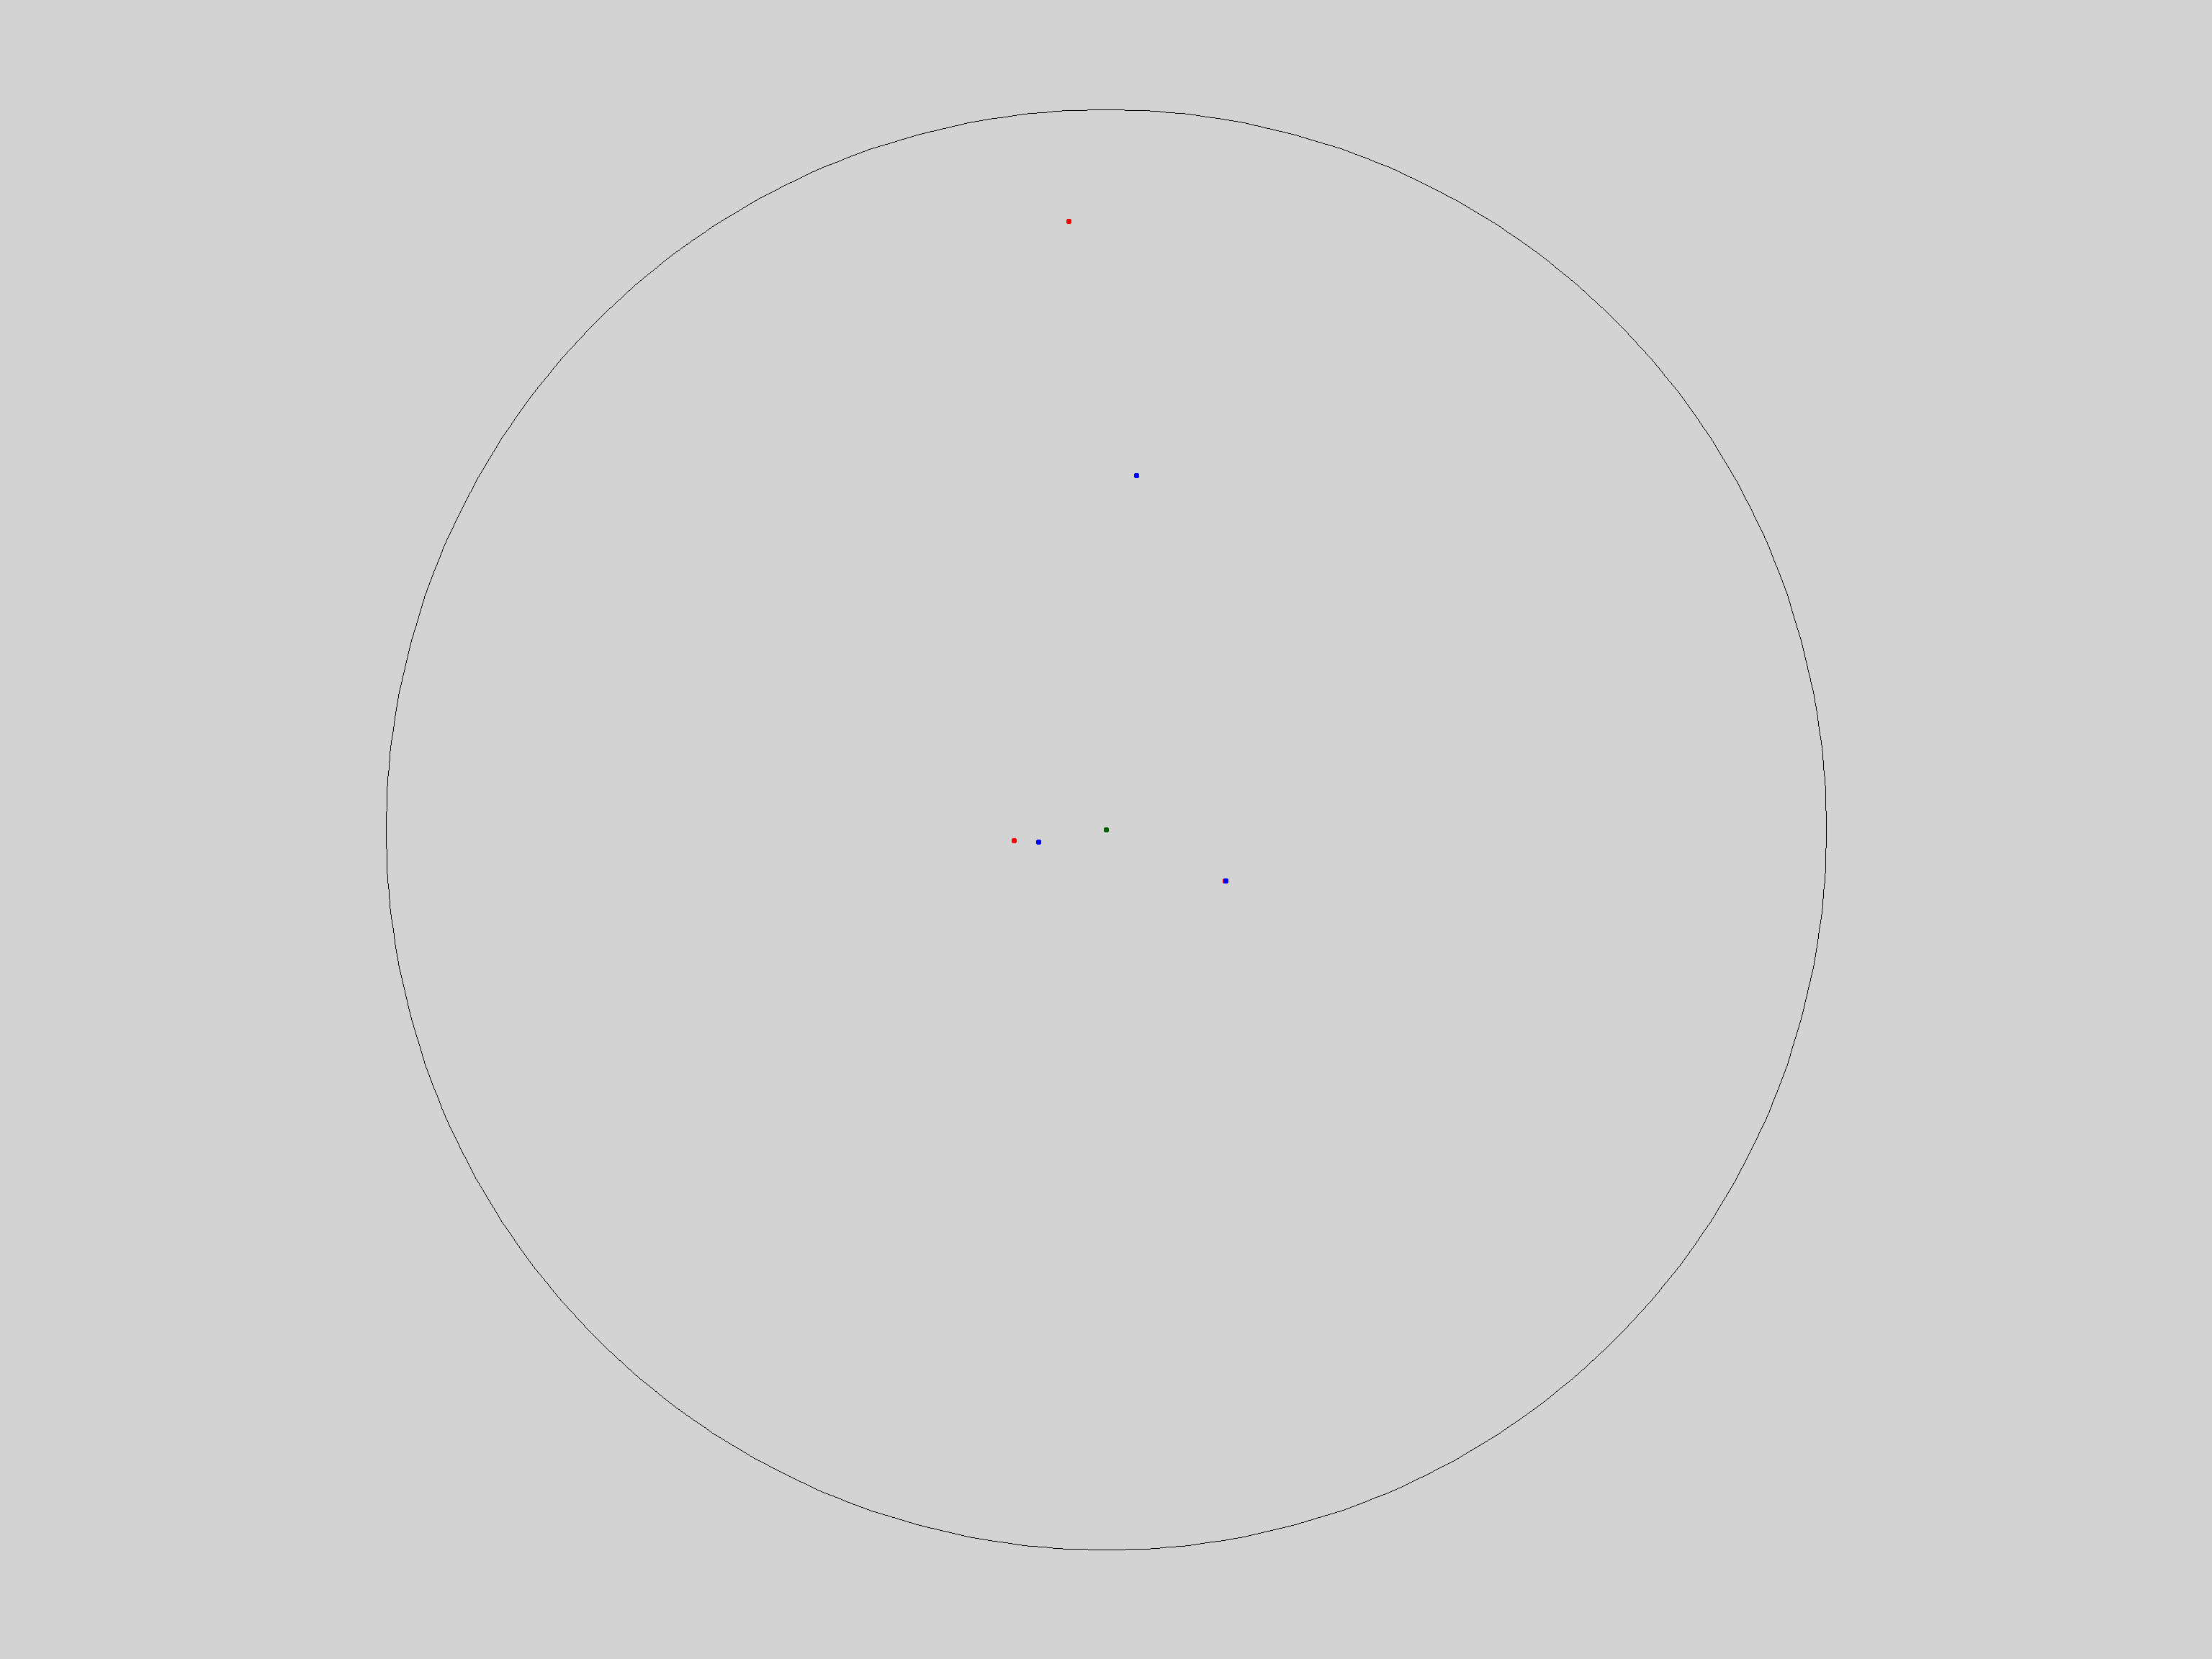

In [52]:
scatter3 = Image.new('RGB', (w, h), 'lightgray')


draw = ImageDraw.Draw(scatter3)
draw.ellipse((x_c-ELL_RAD, y_c-ELL_RAD, x_c+ELL_RAD, y_c+ELL_RAD), fill='darkgreen')
# Draw central part boundary
draw.ellipse((x_c-CENTER_RAD, y_c-CENTER_RAD, x_c+CENTER_RAD, y_c+CENTER_RAD), outline='black')

for i in range(N): # draw star points
    draw.ellipse((nlX3[i]-ELL_RAD, nlY3[i]-ELL_RAD, nlX3[i]+ELL_RAD, nlY3[i]+ELL_RAD), fill='red')
    draw.ellipse((nrX3[i]-ELL_RAD, nrY3[i]-ELL_RAD, nrX3[i]+ELL_RAD, nrY3[i]+ELL_RAD), fill='blue')
scatter3

In [53]:
"""
c) Affine + Ditortion3,5
""";

In [54]:
a = float(z35[0])
b = float(z35[1])
c = float(z35[2])
d = float(z35[3])
e = float(z35[4])
f = float(z35[5])

eps1 = float(z35[6])
eps2 = float(z35[7])
eps3 = float(z35[8])
eps4 = float(z35[9])

In [55]:
nlX35 = np.zeros_like(lX)
nlY35 = np.zeros_like(lY)
nrX35 = np.zeros_like(rX)
nrY35 = np.zeros_like(rY)

In [56]:
# Get rid of distortions on new left Img
for i in range(N): 
    dist_l = (lX[i] - x_c)**2 + (lY[i] - y_c)**2

    zx1 = (lX[i] - x_c) * dist_l
    zy1 = (lY[i] - y_c) * dist_l
    wx1 = (lX[i] - x_c) * dist_l**2
    wy1 = (lY[i] - y_c) * dist_l**2

    
    nlX35[i] = lX[i] - eps1 * zx1 - eps3 * wx1
    nlY35[i] = lY[i] - eps1 * zy1 - eps3 * wy1


# Get rid of distortions on new right Img

for i in range(N): 
    dist_r = (rX[i] - x_c)**2 + (rY[i] - y_c)**2

    zx2 = (rX[i] - x_c) * dist_r
    zy2 = (rY[i] - y_c) * dist_r
    wx2 = (rX[i] - x_c) * dist_r**2
    wy2 = (rY[i] - y_c) * dist_r**2


    nrX35[i] = rX[i] - eps2 * zx2 - eps4 * wx2
    nrY35[i] = rY[i] - eps2 * zy2 - eps4 * wy2


In [57]:
# Calc new (affine transformed) points
for i in range(N): 
    nlX35[i], nlY35[i] = affine_transform_point(lX[i], lY[i])

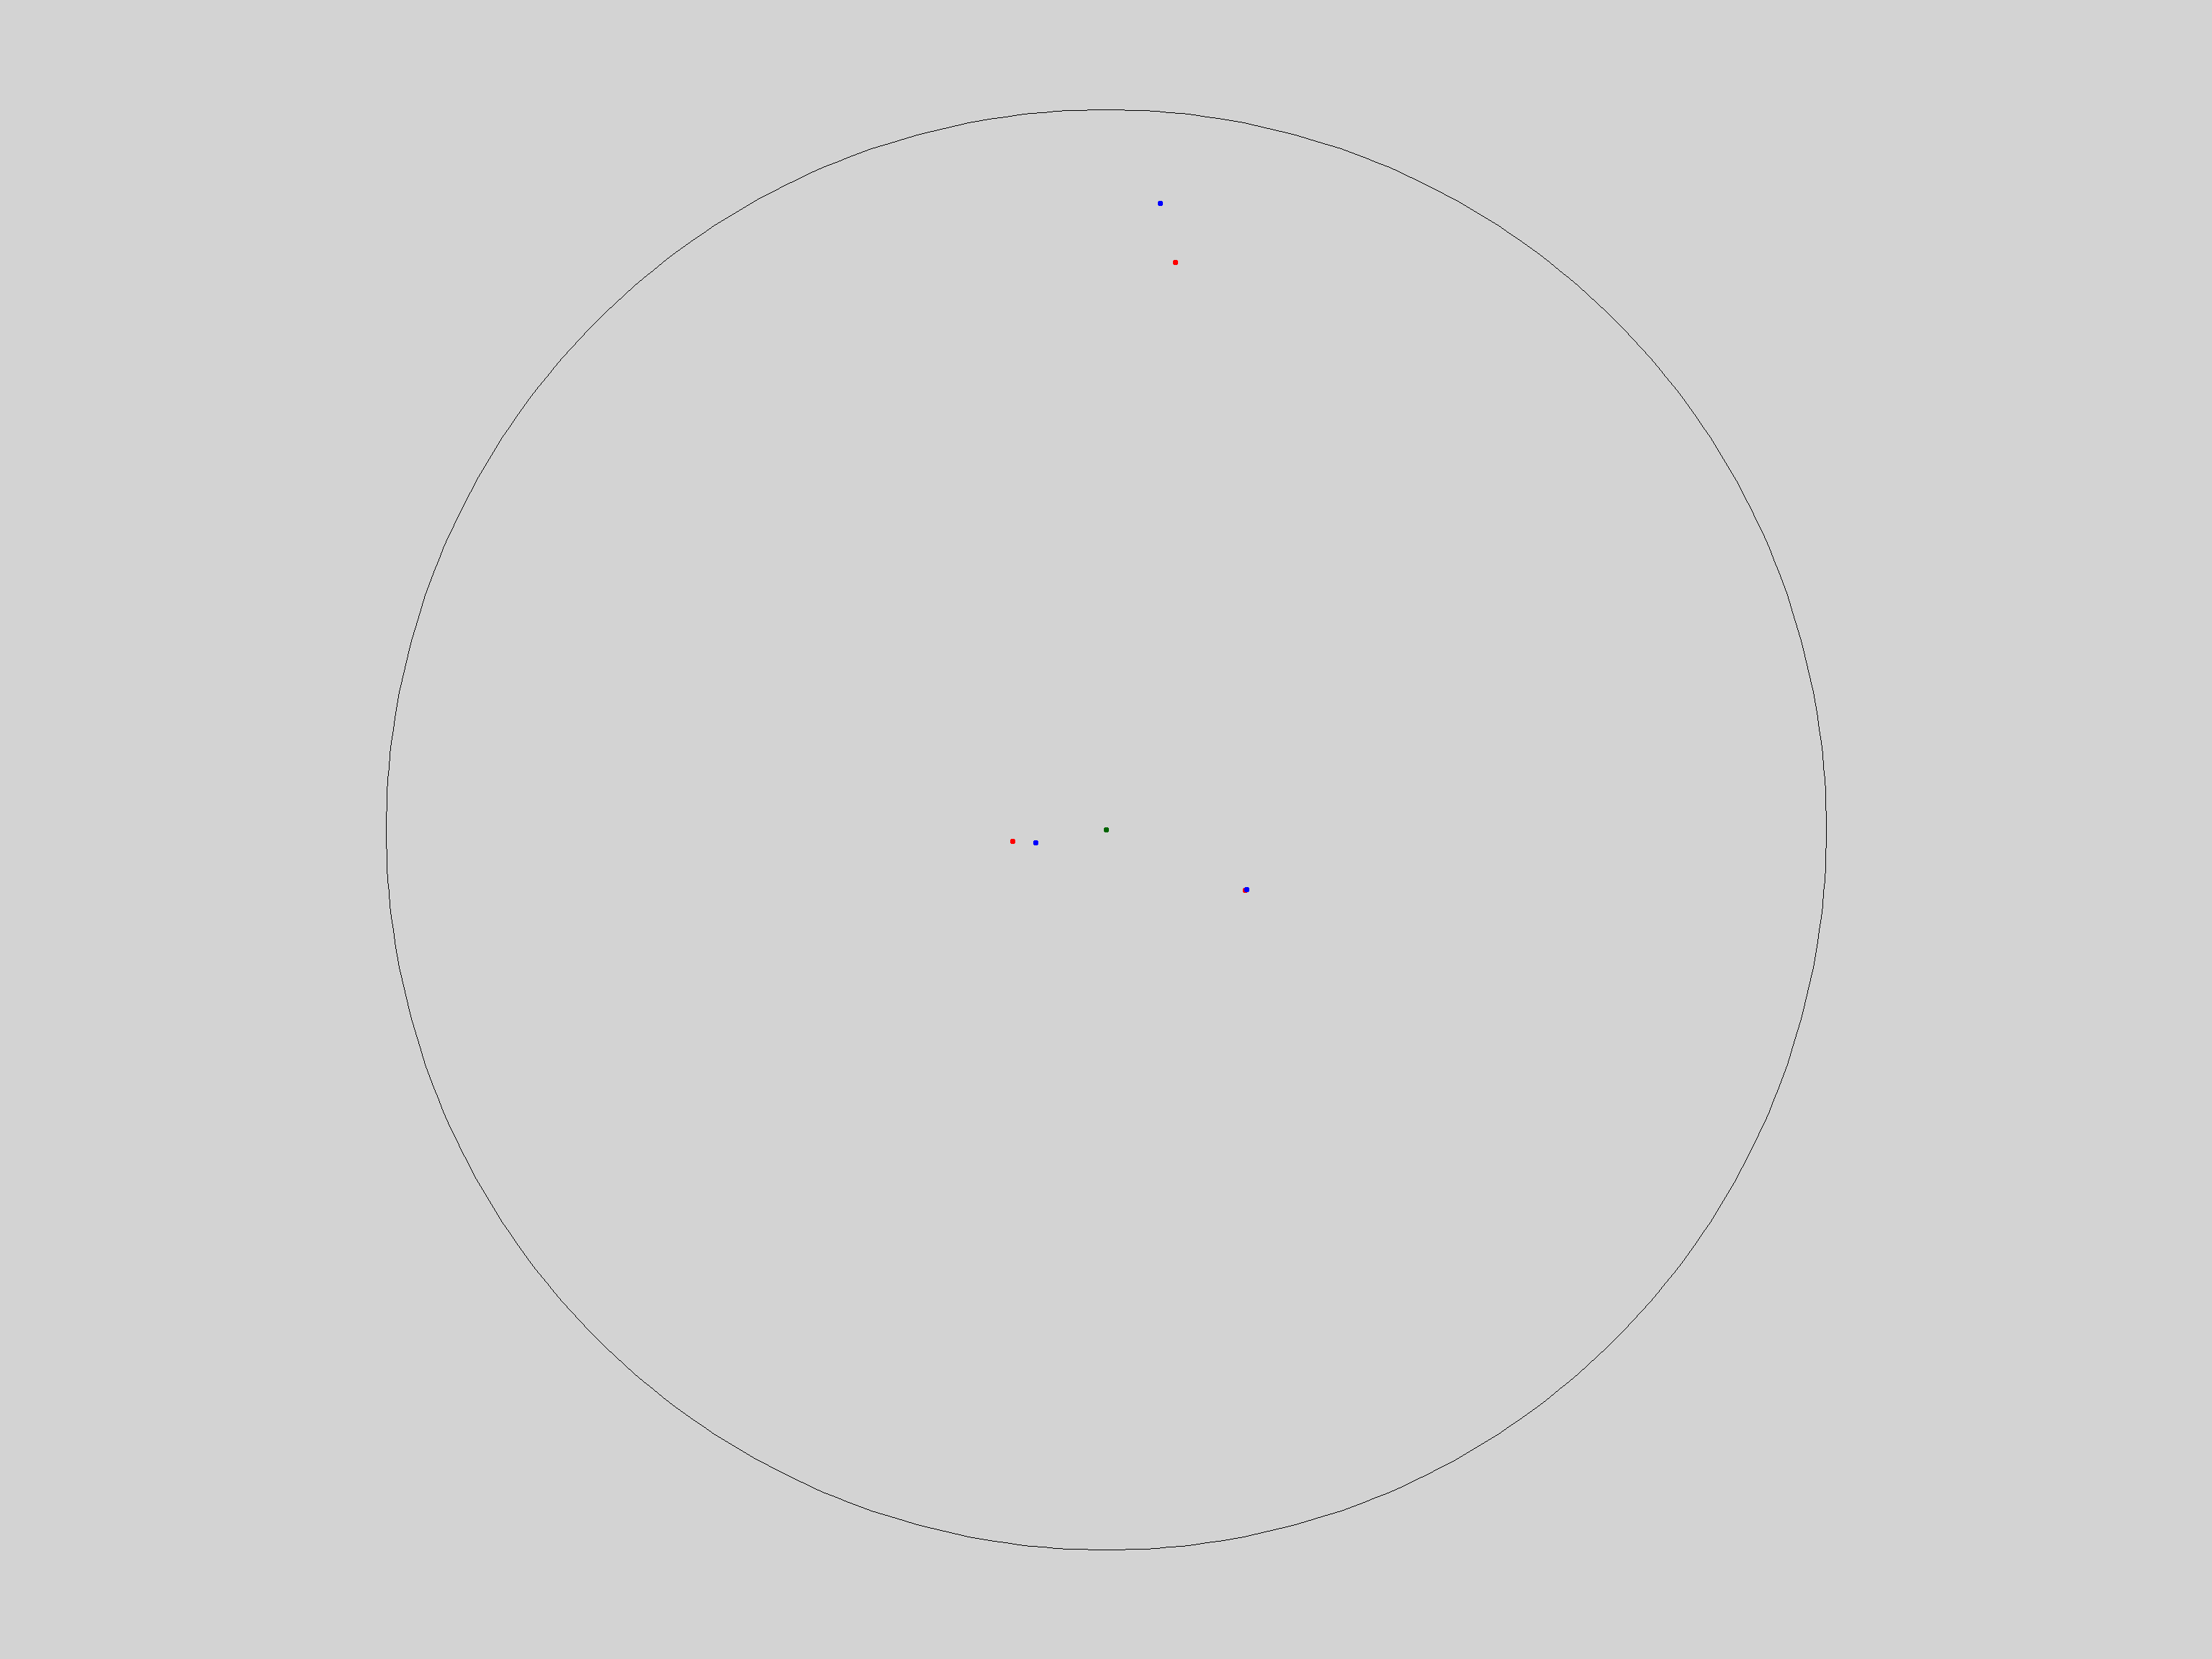

In [58]:
scatter35 = Image.new('RGB', (w, h), 'lightgray')


draw = ImageDraw.Draw(scatter35)
draw.ellipse((x_c-ELL_RAD, y_c-ELL_RAD, x_c+ELL_RAD, y_c+ELL_RAD), fill='darkgreen')
# Draw central part boundary
draw.ellipse((x_c-CENTER_RAD, y_c-CENTER_RAD, x_c+CENTER_RAD, y_c+CENTER_RAD), outline='black')

for i in range(N): # draw star points
    draw.ellipse((nlX35[i]-ELL_RAD, nlY35[i]-ELL_RAD, nlX35[i]+ELL_RAD, nlY35[i]+ELL_RAD), fill='red')
    draw.ellipse((nrX35[i]-ELL_RAD, nrY35[i]-ELL_RAD, nrX35[i]+ELL_RAD, nrY35[i]+ELL_RAD), fill='blue')
scatter35

Выходные данные программы:

1) $\Delta x_i, \Delta y_i, \; i = 1,N$

2) $\sigma^2 = \frac{1}{N} \sum\limits_{i=1}^{N} 
                \left( \Delta x_i^2 + \Delta y_i^2 \right)$
                
3) $ 
     M_x = \max\limits_{i=1,N} \{\Delta x_i\}, \;
     M_y = \max\limits_{i=1,N} \{\Delta y_i\}, \;
     M = \max\{M_x, M_y\}
   $                

In [59]:
"""
For all stars -- calculate distance (by x, by y) 
between corresponding stars on aligned images:
\Delta_x, \Delta_y;
\sigma^2;
M_x, M_y, M
""";

In [60]:
"""
a) Affine
""";

In [61]:
delX = np.zeros_like(nlX)
delY = np.zeros_like(nlY)

In [62]:
delX = abs(nlX - rX)
delY = abs(nlY - rY)
print("delX:", delX)
print("delY:", delY)

delX: [9.0949e-13 9.0949e-13 6.8212e-13 9.0949e-13 9.0949e-13 6.8212e-13]
delY: [3.9790e-13 1.1369e-12 1.1369e-12 3.9790e-13 1.1369e-12 1.1369e-12]


In [63]:
sigSqr = 1.0 / N * sum(delX**2 + delY**2)
mX = max(delX)
mY = max(delY)
m = max(mX, mY)

print("mX: %.4f mY: %.4f m: %.4f" % (mX, mY, m))
print("sigSqr: %.4f" % sigSqr)

mX: 0.0000 mY: 0.0000 m: 0.0000
sigSqr: 0.0000


In [64]:
"""
b) Affine + Ditortion3
""";

In [65]:
delX3 = np.zeros_like(nlX3)
delY3 = np.zeros_like(nlY3)

In [66]:
delX3 = abs(nlX3 - nrX3)
delY3 = abs(nlY3 - nrY3)
print("delX3:", delX3)
print("delY3:", delY3)

delX3: [94.1747  1.5153 34.3545 94.1747  1.5153 34.3545]
delY3: [3.5295e+02 3.0525e-01 2.4169e+00 3.5295e+02 3.0525e-01 2.4169e+00]


In [67]:
sigSqr3 = 1.0 / N * sum(delX3**2 + delY3**2)
mX3 = max(delX3)
mY3 = max(delY3)
m3 = max(mX3, mY3)
print("mX3: %.4f mY3: %.4f m3: %.4f" % (mX3, mY3, m3))

print("sigSqr3: %.4f" % sigSqr3)

mX3: 94.1747 mY3: 352.9467 m3: 352.9467
sigSqr3: 44876.2251


In [68]:
"""
b) Affine + Ditortion3,5
""";

In [69]:
delX35 = np.zeros_like(nlX35)
delY35 = np.zeros_like(nlY35)

In [70]:
delX35 = abs(nlX35 - nrX35)
delY35 = abs(nlY35 - nrY35)
print("delX35:", delX35)
print("delY35:", delY35)

delX35: [21.7866  1.7821 31.405  21.7866  1.7821 31.405 ]
delY35: [81.6345  0.3589  2.2094 81.6345  0.3589  2.2094]


In [71]:
sigSqr35 = 1.0 / N * sum(delX35**2 + delY35**2)
mX35 = max(delX35)
mY35 = max(delY35)
m35 = max(mX35, mY35)

print("mX35: %.4f mY35: %.4f m35: %.4f" % (mX35, mY35, m35))
print("sigSqr35: %.4f" % sigSqr35)

mX35: 31.4050 mY35: 81.6345 m35: 81.6345
sigSqr35: 2711.1030


In [72]:
"""
Save results: mode=("a" / "d3" / "d35")
radius, N, sigma^2, M
""";

In [73]:
res_fname = results_folder + os.sep + "results_a.txt"
res_fname3 = results_folder + os.sep + "results_d3.txt"
res_fname35 = results_folder + os.sep + "results_d35.txt"

In [74]:
print(res_fname)
print(res_fname3)
print(res_fname35)

results/2016nov-11/exp-Feb-2017/results_a.txt
results/2016nov-11/exp-Feb-2017/results_d3.txt
results/2016nov-11/exp-Feb-2017/results_d35.txt


In [75]:
header = "# CENTER_RAD, N, sigSqr, m"
line = " ".join(str(e) for e in [CENTER_RAD, N, sigSqr, m])
print(line)

1000 6 1.6209724243389408e-24 1.1368683772161603e-12


In [76]:
line3 = " ".join(str(e) for e in [CENTER_RAD, N, sigSqr3, m3])
print(line3)

1000 6 44876.22510976672 352.9466591460946


In [77]:
line35 = " ".join(str(e) for e in [CENTER_RAD, N, sigSqr35, m35])
print(line35)

1000 6 2711.103036420858 81.63451894147317


In [78]:
def write_to_file(res_fname, line):
    # if file exists -- append
    if os.path.isfile(res_fname):
        with open(res_fname, 'a') as fout:
            fout.write(line)
            fout.write('\n')

    # If file doest exist -- create new
    else:
        with open(res_fname, 'w') as fout:
            fout.write(header)
            fout.write('\n')
            fout.write(line)
            fout.write('\n')

In [79]:
write_to_file(res_fname, line)
write_to_file(res_fname3, line3)
write_to_file(res_fname35, line35)

"4." Построить графики зависимости $\sigma$ и $M$ от размера круга для аффинного, аффин+дист.3 порядка и аффин+дист.3 порядка+дист 5
порядка.

In [80]:
"""
Plot graph sigma^2(radius), M(radius)
""";

In [81]:
# Load data from files "results_a.txt, results_d3.txt, results_d35.txt"
# (without header -- 1st string)
# load to arrays resA, resD3, resD35


In [82]:
# Make data unique in resA, resD3, resD35 
# (remove duplicating rows)

In [83]:
# Make arrays of radius, Num stars, sigma Squared, M

In [84]:
# Plot sigma^2(radius), M(radius) with 3 curves on each (A, D3, D35)